##### 02_bootstrap_RNN.ipynb

### Author: Lewis Kunik - University of Utah
### Contact: lewiskunik@gmail.com

##### <u>Description:</u>
This notebook demonstrates how to perform the bootstrap-based recurrent neural network described in the paper:
Kunik et al. (2025) Can we detect forest mortality using satellite observations of solar-induced chlorophyll fluorescence?

This code takes NIRv time series data processed from the MODIS MCD43A4 dataset for the super-set of all "severe" bark beetle mortality pixels and "control" pixels within the Sierra Nevada, Klamath Mountains and Cascades ecoregions described in the paper. The code randomly samples time series from the mortality pixels to use as training data and then samples the control pixel set using the same multiKDE-resampling method demonstrated in 01_multiKDE_bootstrap.ipynb in order for the control pixel sample group to match the geographic charactaristics of the mortality pixel sample group.

First load necessary packages and functions:


In [1]:

# File system packages
import os  # operating system library
import sys
import pickle

# identify the include directory and add it to the system path
sys.path.append('include')
import bootstrap_map_functions as map_functions
import RNN_functions as functions

# runtime packages
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# numerical/data management packages
import numpy as np
import pandas as pd

# stats packages
from scipy.stats import gaussian_kde
import random

# time and date packages
import time
from datetime import datetime as dt  # date time library


# plotting packages
from matplotlib import pyplot as plt  # primary plotting module
import matplotlib.dates as mdates

# machine learning packages
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score



2025-07-10 16:09:55.542002: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-10 16:09:55.556279: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752185395.575069  522564 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752185395.581389  522564 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-10 16:09:55.600102: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Now define global filepaths and variables:

In [2]:
########################################
# Define Global filepaths
#########################################

# directories
dat_dir = 'data/time_series/'

########################################
# Define Global Variables and constants
#########################################

mortality_year = 2021
late_summer_months = [8, 9, 10]
pre_mortality_years_buff = 19 # years of pre-mortality data to use for training

# Define parameters for Kernel Density Estimation of land surface characteristic distributions
elevation_bin = 100 # meters
elevation_range = np.linspace(0, 4000, 1000)#[:, None]  #uncomment the [:, None] if using 1D KDE
TCC_bin = 5 # percent
TCC_range = np.linspace(0, 100, 1000)#[:, None] #uncomment the [:, None] if using 1D KDE

model_config = {
 'activation': 'relu',
 'batch_size': 32,
 'dense_units': 16,
 'dropout_rate': 0.3,
 'loss': 'binary_crossentropy',
 'n_attention_months': 9,
 'n_epochs': 100,
 'n_folds': 5,
 'optimizer': 'adam',
 'patience': 15,
 'rnn_units_stack1': 64,
 'rnn_units_stack2': 32}

# Colors for plotting
mortality_color = "#aa021e" # Line/point color for plots
control_color = "#0219aa"

rand_seed = 0
num_sample_pixels = 100


For simplicity, functions are stored in the RNN_functions.py and bootstrap_map_functions.py files in the include directory

In [3]:
#########################################
# Define Global Functions
#########################################

# See "include/RNN_functions.py" and "include/bootstrap_map_functions.py" for the functions used in this script

# Set global matplotlib font sizes for axes and legends
plt.rcParams.update({
   'axes.labelsize': 16,
   'axes.titlesize': 18,
   'xtick.labelsize': 14,
   'ytick.labelsize': 14,
   'legend.fontsize': 14
})

Start by loading the mortality and control NIRv time series data, which are pre-processed and stored as "pickle" files for space efficiency and easy re-loading into python

The time series data are loaded in as "stacked" xarray Dataset objects, meaning that instead of dimensions of (x, y, time) these are pre-flattened to dimensions of (pixel, time) for easier processing.

Each xarray Dataset contains NIRv, elevation and tree_canopy_cover variables

In [4]:
ts_begin_year = mortality_year - pre_mortality_years_buff

ML_start_date = dt.strptime(f'{ts_begin_year}-01-01', '%Y-%m-%d')
ML_end_date = dt.strptime(f'{mortality_year}-12-01', '%Y-%m-%d')

# Define the time series pickel files for control and mortality
mortality_dat_file = os.path.join(dat_dir, f'MCD43A4_NIRv_mortality{mortality_year}_01d_time_series_stacked.pkl')
control_dat_file = os.path.join(dat_dir, f'MCD43A4_NIRv_Control{mortality_year}_01d_time_series_stacked.pkl')

print(f'loading NIRv data for mortality pixels from the {mortality_year} mortality year')

with open(mortality_dat_file, 'rb') as f:
   mortality_xr_stacked = pickle.load(f)

mortality_xr_stacked

loading NIRv data for mortality pixels from the 2021 mortality year


<xarray.Dataset> Size: 5MB
Dimensions:            (time: 1074, pixel: 539)
Coordinates:
  * time               (time) datetime64[ns] 9kB 2000-02-24 ... 2023-12-27
    crs                int64 8B 0
    band               int64 8B 1
    spatial_ref        int64 8B 0
  * pixel              (pixel) object 4kB MultiIndex
  * y                  (pixel) float64 4kB 35.02 36.54 36.54 ... 43.49 43.49
  * x                  (pixel) float64 4kB -118.5 -118.7 ... -123.2 -123.2
Data variables:
    NIRv               (time, pixel) float64 5MB 0.1102 0.1845 ... 0.0851 0.2283
    elevation          (pixel) float64 4kB 1.623e+03 1.431e+03 ... 462.1 514.2
    tree_canopy_cover  (pixel) float32 2kB 35.75 48.57 49.48 ... 67.71 73.59
Attributes:
    long_name:  Near-infrared Reflectance of Vegetation (NIRv)
    formula:    (B2 - B1) * B2 / (B2 + B1)
    units:      unitless

In [5]:
print(f'loading NIRv data for control pixels corresponding to the {mortality_year} mortality year')

# Load the control pickle file
with open(control_dat_file, 'rb') as f:
   control_xr_stacked = pickle.load(f)

control_xr_stacked

loading NIRv data for control pixels corresponding to the 2021 mortality year


<xarray.Dataset> Size: 68MB
Dimensions:            (time: 1074, pixel: 7873)
Coordinates:
  * time               (time) datetime64[ns] 9kB 2000-02-24 ... 2023-12-27
    crs                int64 8B 0
    band               int64 8B 1
    spatial_ref        int64 8B 0
  * pixel              (pixel) object 63kB MultiIndex
  * y                  (pixel) float64 63kB 35.97 36.05 36.06 ... 43.71 43.72
  * x                  (pixel) float64 63kB -118.3 -118.1 ... -123.3 -123.4
Data variables:
    NIRv               (time, pixel) float64 68MB 0.05891 0.04991 ... 0.2018
    elevation          (pixel) float64 63kB 2.057e+03 1.891e+03 ... 176.5 347.8
    tree_canopy_cover  (pixel) float32 31kB 20.15 17.75 23.87 ... 72.13 69.94
Attributes:
    long_name:  Near-infrared Reflectance of Vegetation (NIRv)
    formula:    (B2 - B1) * B2 / (B2 + B1)
    units:      unitless

In [6]:
# define the indices from 0 to the number of pixels in each dataset
mortality_xr_indices = list(range(mortality_xr_stacked.pixel.size))
control_xr_indices = list(range(control_xr_stacked.pixel.size))

# extract the elevation and tree canopy cover (TCC) data from control pixels
control_xr_elevations = control_xr_stacked['elevation'].values
control_xr_elevation_mean = np.nanmean(control_xr_elevations)
control_xr_TCC = control_xr_stacked['tree_canopy_cover'].values
control_xr_TCC_mean = np.nanmean(control_xr_TCC)

# Now find the distributions of elevation and TCC for the sampled control pixels
elev_control_original_non_nan = control_xr_elevations[~np.isnan(control_xr_elevations)]
TCC_control_original_non_nan = control_xr_TCC[~np.isnan(control_xr_TCC)]

# Fit Kernel Density Estimators using gaussian_kde for all vars
elev_control_original_kde = gaussian_kde(elev_control_original_non_nan, bw_method = 'scott')
TCC_control_original_kde = gaussian_kde(TCC_control_original_non_nan, bw_method = 'scott')

# Evaluate KDE for density estimation
elev_control_original_density = elev_control_original_kde.evaluate(elevation_range)
TCC_control_original_density = TCC_control_original_kde.evaluate(TCC_range)


Now we will randomly sample pixels from the mortality dataset to use as training data for the RNN. The number of pixels to sample is defined by the num_sample_pixels variable, set to 100 by default.

We will then extract the elevation and tree canopy cover values from those pixels to define KDE distributions for the control pixels to match.


In [7]:
# Randomly sample pixels from the mortality dataset
random.seed(rand_seed)
mortality_xr_sample_indices = random.choices(mortality_xr_indices, k=num_sample_pixels) # Randomly select pixel indices

# Convert to numpy arrays
mortality_ts_full_arr, mortality_elev_array, mortality_TCC_array, mortality_timestamps_full_arr, mortality_coords = functions.sample_xarray_stacked(mortality_xr_stacked, mortality_xr_sample_indices, ML_start_date, ML_end_date)
functions.check_all_lengths_in_arr(mortality_ts_full_arr)

# Performa a sanity check of the NIRv values in mortality_ts_full_arr to ensure there are no infinity or NaN values
mortality_ts_full_arr = functions.cap_and_replace_inf_nan(mortality_ts_full_arr)

# Now find the distributions of elevation and TCC for the sampled mortality pixels
elev_mortality_non_nan = mortality_elev_array[~np.isnan(mortality_elev_array)]
TCC_mortality_non_nan = mortality_TCC_array[~np.isnan(mortality_TCC_array)]

# Fit Kernel Density Estimators using gaussian_kde for all vars
elev_mortality_kde = gaussian_kde(elev_mortality_non_nan, bw_method = 'scott')
TCC_mortality_kde = gaussian_kde(TCC_mortality_non_nan, bw_method = 'scott')

# Evaluate KDE for density estimation
elev_mortality_density = elev_mortality_kde.evaluate(elevation_range)
TCC_mortality_density = TCC_mortality_kde.evaluate(TCC_range)



All elements in input array have the same length {896}.


Now we will randomly sample from the distributions of elevation and tree canopy cover and match these to the control pixels by taking the minimum difference between sampled elevation and TCC values and those of the original set of control pixels.

In [8]:
# Sample new values based on the densities
sampled_elev_values = elev_mortality_kde.resample(num_sample_pixels).flatten()
sampled_TCC_values = TCC_mortality_kde.resample(num_sample_pixels).flatten()

# Find indices in the control domain where both elevation and LAI match closely
matching_indices = []

for elev_val, TCC_val in zip(sampled_elev_values, sampled_TCC_values):
   # Calculate the normalized differences of each var
   elev_diffs = np.abs(control_xr_elevations - elev_val)/control_xr_elevation_mean # divide by mean to normalize
   TCC_diffs = np.abs(control_xr_TCC - TCC_val)/control_xr_TCC_mean # divide by mean to normalize
   
   # Combine constraints: find indices where combined differences are minimal
   overall_diffs = elev_diffs + TCC_diffs
   matching_idx = np.nanargmin(overall_diffs) # identify the index of the minimum difference
   
   # Append the index if not already present (retains only unique pixels)
   if matching_idx not in matching_indices:
      matching_indices.append(matching_idx)

control_xr_sample_indices = random.choices(matching_indices, k=num_sample_pixels)
control_ts_full_arr, control_elev_array, control_TCC_array, control_timestamps_full_arr, control_coords = functions.sample_xarray_stacked(control_xr_stacked, control_xr_sample_indices, ML_start_date, ML_end_date)
functions.check_all_lengths_in_arr(control_ts_full_arr)

# Cap and replace inf/nan in control_ts_full_arr
control_ts_full_arr = functions.cap_and_replace_inf_nan(control_ts_full_arr)


# Now find the distributions of elevation and TCC for the sampled control pixels
elev_control_sampled_non_nan = control_elev_array[~np.isnan(control_elev_array)]
TCC_control_sampled_non_nan = control_TCC_array[~np.isnan(control_TCC_array)]

# Fit Kernel Density Estimators using gaussian_kde for all vars
elev_control_sampled_kde = gaussian_kde(elev_control_sampled_non_nan, bw_method = 'scott')
TCC_control_sampled_kde = gaussian_kde(TCC_control_sampled_non_nan, bw_method = 'scott')

# Evaluate KDE for density estimation
elev_control_sampled_density = elev_control_sampled_kde.evaluate(elevation_range)
TCC_control_sampled_density = TCC_control_sampled_kde.evaluate(TCC_range)

All elements in input array have the same length {896}.


To visualize the spatial distributions of the pixels selected, we will plot a map of the sampled mortality and control pixels:

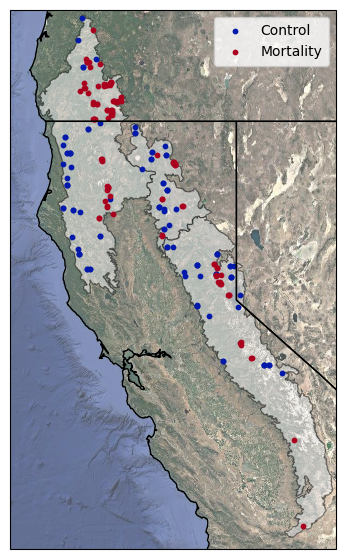

In [9]:

# Convert mortality_coords and control_coords to DataFrames with columns 'x' and 'y'
mortality_centroids = pd.DataFrame({
   'y': [coord[0] for coord in mortality_coords],
   'x': [coord[1] for coord in mortality_coords]
})
control_centroids = pd.DataFrame({
   'y': [coord[0] for coord in control_coords],
   'x': [coord[1] for coord in control_coords]
})

# Here's a map of the mortality and control pixels selected:
map_functions.plot_mortality_control_pixel_map(control_centroids, mortality_centroids)

We can also visualize the distributions of these pixels in terms of their elevation and TCC values:


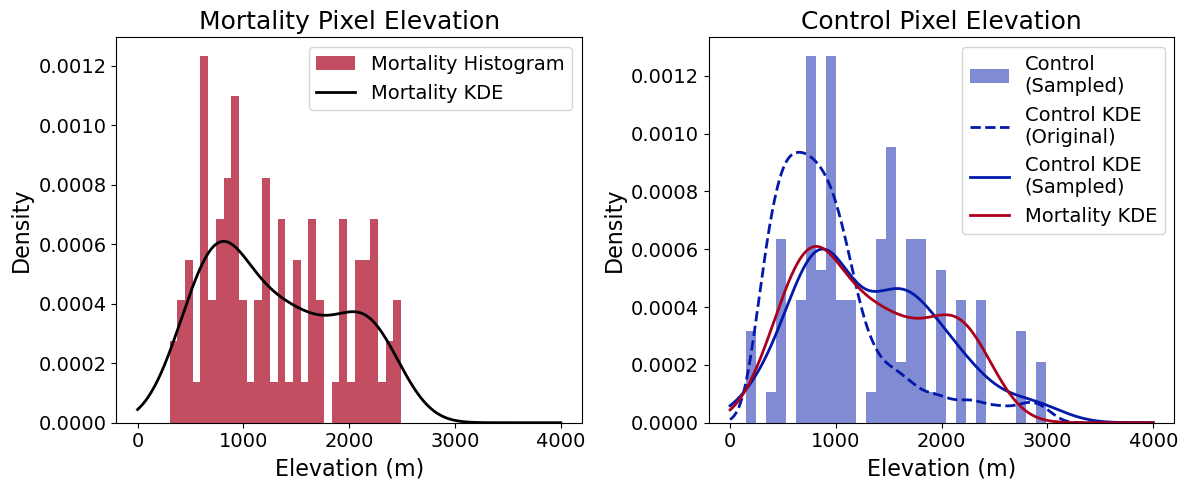

In [10]:
# Plot histograms of elev_mortality_non_nan and elev_control_non_nan with KDE overlays
plt.figure(figsize=(12, 5))

# Elevation histogram + KDE for Mortality
plt.subplot(1, 2, 1)
plt.hist(elev_mortality_non_nan, bins=30, color=mortality_color, alpha=0.7, density=True, label='Mortality Histogram')
plt.plot(elevation_range, elev_mortality_density, color='black', linewidth=2, label='Mortality KDE')
plt.xlabel('Elevation (m)')
plt.ylabel('Density')
plt.title('Mortality Pixel Elevation')
plt.legend()


# Elevation histogram + KDE for Control
plt.subplot(1, 2, 2)
plt.hist(elev_control_sampled_non_nan, bins=30, color=control_color, alpha=0.5, density=True, label='Control\n(Sampled)')
plt.plot(elevation_range, elev_control_original_density, color=control_color, linestyle='--', linewidth=2, label='Control KDE\n(Original)')
plt.plot(elevation_range, elev_control_sampled_density, color=control_color, linewidth=2, label='Control KDE\n(Sampled)')
plt.plot(elevation_range, elev_mortality_density, color=mortality_color, linewidth=2, label='Mortality KDE')
plt.xlabel('Elevation (m)')
plt.ylabel('Density')
plt.title('Control Pixel Elevation')
plt.legend()


plt.tight_layout()
plt.show()


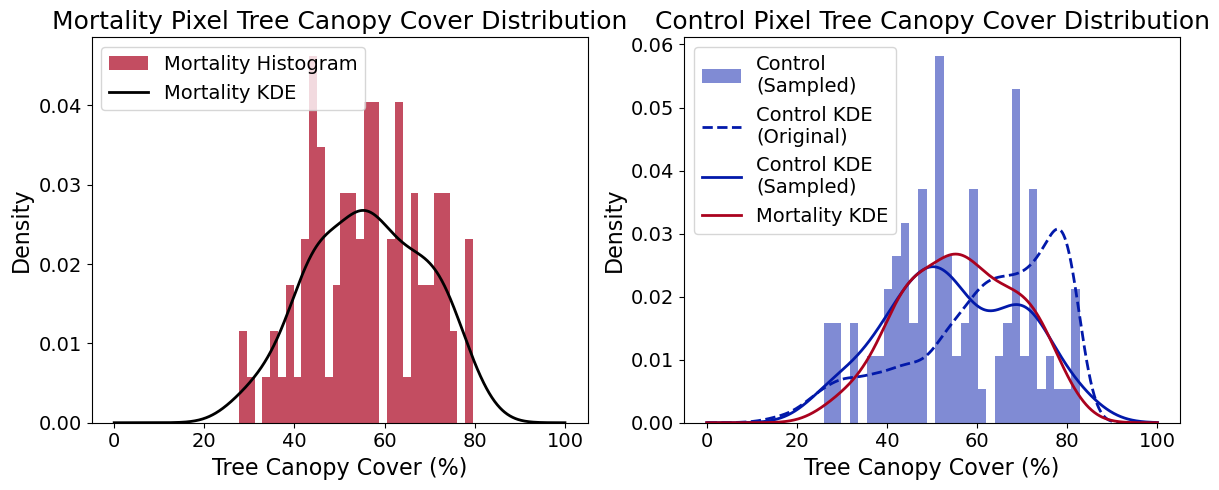

In [11]:
# Plot histograms of TCC_mortality_non_nan and TCC_control_non_nan with KDE overlays
plt.figure(figsize=(12, 5))

# Tree canopy cover histogram + KDE for Mortality
plt.subplot(1, 2, 1)
plt.hist(TCC_mortality_non_nan, bins=30, color=mortality_color, alpha=0.7, density=True, label='Mortality Histogram')
plt.plot(TCC_range, TCC_mortality_density, color='black', linewidth=2, label='Mortality KDE')
plt.xlabel('Tree Canopy Cover (%)')
plt.ylabel('Density')
plt.title('Mortality Pixel Tree Canopy Cover Distribution')
plt.legend()


# Tree canopy cover histogram + KDE for Control
plt.subplot(1, 2, 2)
plt.hist(TCC_control_sampled_non_nan, bins=30, color=control_color, alpha=0.5, density=True, label='Control\n(Sampled)')
plt.plot(TCC_range, TCC_control_original_density, color=control_color, linestyle='--', linewidth=2, label='Control KDE\n(Original)')
plt.plot(TCC_range, TCC_control_sampled_density, color=control_color, linewidth=2, label='Control KDE\n(Sampled)')
plt.plot(TCC_range, TCC_mortality_density, color=mortality_color, linewidth=2, label='Mortality KDE')
plt.xlabel('Tree Canopy Cover (%)')
plt.ylabel('Density')
plt.title('Control Pixel Tree Canopy Cover Distribution')
plt.legend()


plt.tight_layout()
plt.show()


The time series data that we just loaded contain NIRv values for all timesteps throughout the season, but we will only use data from late summer, which we defined as the months of August, September and October. Let's filter these data:

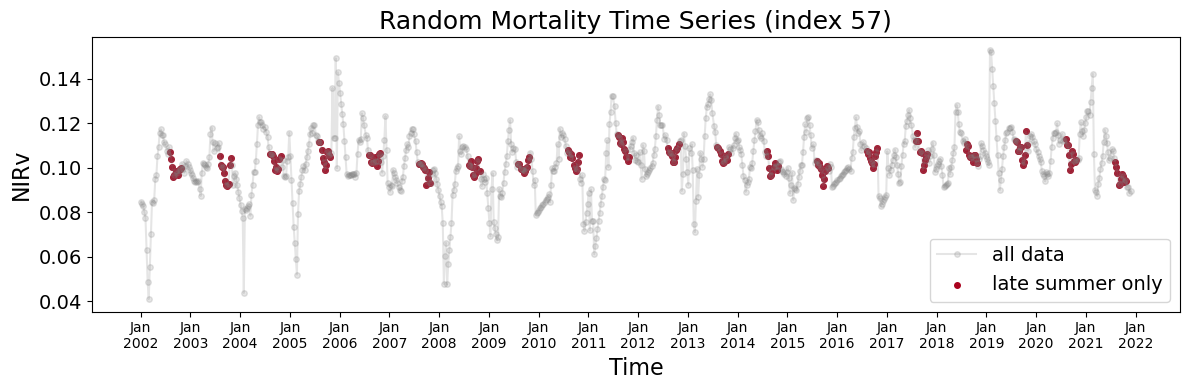

In [12]:

# Filter away all timesteps outside of the late summer months
# Subset each time series for late summer months only

### Mortality
mortality_ts_latesummer_arr = []
mortality_timestamps_latesummer_arr = []

for ii in range(len(mortality_ts_full_arr)):
   full_timestamps = mortality_timestamps_full_arr[ii]
   # Convert numpy datetime64 array to pandas DatetimeIndex for month filtering
   full_timestamps_pd = pd.to_datetime(full_timestamps)
   latesummer_mask = pd.Series(full_timestamps_pd.month).isin(late_summer_months)
   latesummer_timestamps = full_timestamps[latesummer_mask.values]
   mortality_timestamps_latesummer_arr.append(latesummer_timestamps)
   mortality_ts_latesummer_arr.append(mortality_ts_full_arr[ii][latesummer_mask.values])

# Check random time series from mortality to make sure it's formatted correctly
random_idx = random.randint(0, len(mortality_ts_full_arr) - 1)
series_full = mortality_ts_full_arr[random_idx]
series_latesummer = mortality_ts_latesummer_arr[random_idx]
ts_full = mortality_timestamps_full_arr[random_idx]
ts_latesummer = mortality_timestamps_latesummer_arr[random_idx]


plt.figure(figsize=(12, 4))
plt.plot(ts_full, series_full, marker='o', markersize=4, color = 'gray', alpha = 0.2, label='all data')
plt.scatter(ts_latesummer, series_latesummer, marker='o', s=16, color = mortality_color, label='late summer only')
plt.title(f'Random Mortality Time Series (index {random_idx})')

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))
plt.setp(ax.xaxis.get_minorticklabels(), rotation=90, fontsize=8)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=0, fontsize=10)
plt.xlabel('Time')
plt.ylabel('NIRv')
plt.tight_layout()
plt.legend()
plt.show()



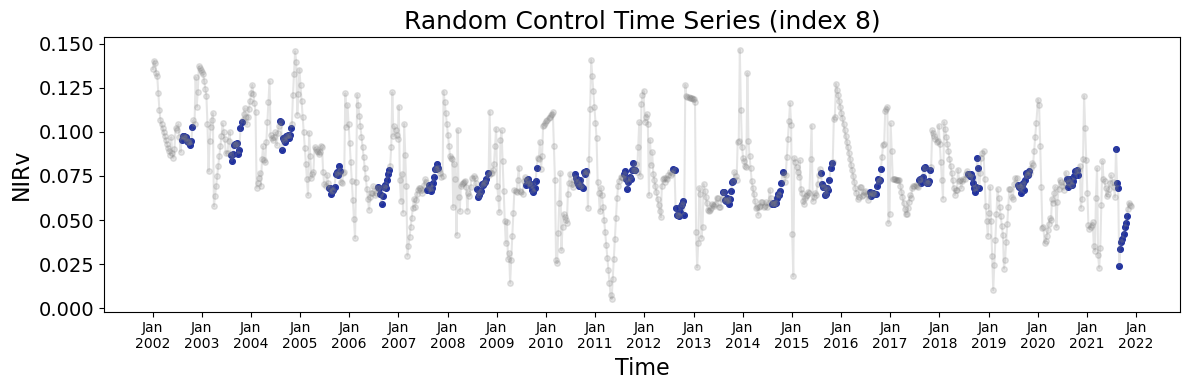

In [13]:

### Control
control_ts_latesummer_arr = []
control_timestamps_latesummer_arr = []

for ii in range(len(control_ts_full_arr)):
   full_timestamps = control_timestamps_full_arr[ii]
   # Convert numpy datetime64 array to pandas DatetimeIndex for month filtering
   full_timestamps_pd = pd.to_datetime(full_timestamps)
   latesummer_mask = pd.Series(full_timestamps_pd.month).isin(late_summer_months)
   latesummer_timestamps = full_timestamps[latesummer_mask.values]
   control_timestamps_latesummer_arr.append(latesummer_timestamps)
   control_ts_latesummer_arr.append(control_ts_full_arr[ii][latesummer_mask.values])


# Check random time series from control to make sure it's formatted correctly

random_idx = random.randint(0, len(control_ts_full_arr) - 1)
series_full = control_ts_full_arr[random_idx]
series_latesummer = control_ts_latesummer_arr[random_idx]
ts_full = control_timestamps_full_arr[random_idx]
ts_latesummer = control_timestamps_latesummer_arr[random_idx]

plt.figure(figsize=(12, 4))
plt.plot(ts_full, series_full, marker='o', markersize=4, color = 'gray', alpha = 0.2, label='all data')
plt.scatter(ts_latesummer, series_latesummer, marker='o', s=16, color = control_color, label='late summer only')
plt.title(f'Random Control Time Series (index {random_idx})')
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))
plt.setp(ax.xaxis.get_minorticklabels(), rotation=90, fontsize=8)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=0, fontsize=10)
plt.xlabel('Time')
plt.ylabel('NIRv')
plt.tight_layout()
plt.show()

Now the time series data are ready to be used as input to the recurrent neural network. We define binary labels for the control and mortality time series (0 or 1, where 0 indicates that the time series is from a control pixel and 1 indicates that it is from a mortality pixel).

In [15]:
# Create labels (0 for control, 1 for mortality)
control_labels = np.zeros(len(control_ts_latesummer_arr))
mortality_labels = np.ones(len(mortality_ts_latesummer_arr))

# Combine timestamps the same way you combine data
all_timestamps = np.vstack((control_timestamps_latesummer_arr, mortality_timestamps_latesummer_arr))

# Combine data and labels
X = np.vstack((control_ts_latesummer_arr, mortality_ts_latesummer_arr))
Y = np.concatenate((control_labels, mortality_labels))
timestamps = np.array(all_timestamps, dtype=object)  # Keep as object array due to potential different lengths



# Convert to TensorFlow tensors explicitly
X_tensor = tf.convert_to_tensor(X, dtype=tf.float32)
Y_tensor = tf.convert_to_tensor(Y, dtype=tf.float32)


For the real RNN analysis, we perform model training and evaluation using "k-fold cross-validation" which will split the data into k number of folds, and will loop through all folds, iteratively leaving out one "fold" of the data from training in order to use for validation and taking the average performance across all of these iterations of the loop.

We will demonstrate how this work at the end of the notebook, but first we will step through one iteration of this process to demonstrate how the RNN is trained and evaluated.

In [16]:

# Split into training and testing sets
indices = np.arange(len(X))
train_indices, test_indices = train_test_split(
    indices, test_size=(1/model_config['n_folds']), random_state=rand_seed, 
    stratify=Y_tensor.numpy()
)

X_train, X_test = X[train_indices], X[test_indices]
Y_train, Y_test = Y[train_indices], Y[test_indices]
timestamps_train = [timestamps[i] for i in train_indices]
timestamps_test = [timestamps[i] for i in test_indices]

# Normalize the data so the model can interpret the NIRv values
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reshape for time series model - requires 3D input
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Convert back to tensors after preprocessing
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
Y_train = tf.convert_to_tensor(Y_train, dtype=tf.float32)
Y_test = tf.convert_to_tensor(Y_test, dtype=tf.float32)

# Print shapes to check everything is correct
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
print("X_test shape:", X_test.shape)
print("Y_test shape:", Y_test.shape)


X_train shape: (160, 221, 1)
Y_train shape: (160,)
X_test shape: (40, 221, 1)
Y_test shape: (40,)


Now we define the layers of the RNN:

In [17]:

inputs = tf.keras.Input(shape=(X_train.shape[1], 1)) #Input Layer
normalized = layers.BatchNormalization()(inputs) # Batch normalization
# RNN layers
rnn_out = layers.SimpleRNN(model_config['rnn_units_stack1'], return_sequences=True)(normalized)
attention_mask = functions.create_attention_mask(X_train.shape[1], 5) # Create and apply attention mask
masked_rnn = rnn_out * attention_mask  # Apply the mask directly (static attention)
rnn_out2 = layers.SimpleRNN(model_config['rnn_units_stack2'])(masked_rnn) # Continue with the second RNN layer
dropout = layers.Dropout(0.3)(rnn_out2) # Dropout for regularization
# dropout = layers.Dropout(0.3)(masked_rnn)
dense = layers.Dense(model_config['dense_units'], activation='relu')(dropout) # Dense layers
outputs = layers.Dense(1, activation='sigmoid')(dense)
model = tf.keras.Model(inputs=inputs, outputs=outputs) # Create model


Next, compile the model, specifying the optimizer method, the loss function, and the metrics (accuracy, precision, and recall) that it will keep track of during training.

The optimizer used here is the Adaptive Moment Estimation (Adam) optimizer, which is a stochastic gradient descent method based on first-order and second-order moments. For more information, see https://keras.io/api/optimizers/adam/ and the original paper by Kingma and Ba (2014): https://arxiv.org/abs/1412.6980.

We use the binary cross-entropy loss function, which is a reasonable loss function for binary classification. An informal explanation of this loss function can be found here: https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a/

Training metrics:

- Accuracy refers to number of correct classifications ("true positives" + "false negatives") divided by the total number of classifications ("of all the classifications made, how many were correct?")

- Precision refers to the number of true positives divided by the number of true positives plus false positives ("of all the positive classifications made, how many were correct?")

- Recall refers to the number of true positives divided by the number of true positives plus false negatives ("of all the actual positive instances, how many were correctly classified?")


In [18]:
# Compile the model
model.compile(
   optimizer=model_config['optimizer'], # Adam (Adaptive Moment Estimation) optimizer
   loss=model_config['loss'], # Binary cross-entropy loss function
   metrics=['accuracy', 'precision', 'recall']
)


Now we will train the model using pre-determined "hyperparameters" for the number of epochs, batch size, and validation split. The validation split is the percentage of the training data that will be set aside to validate the model's performance during training. Here we chose 20% of the training data to be used for validation.

In [19]:
# Train the model
history = model.fit(
   X_train, Y_train,
   epochs=model_config['n_epochs'], # set to 100
   batch_size=model_config['batch_size'], # set to 32
   validation_split=(1/model_config['n_folds']), # 20% (number of folds = 5)
   callbacks=[
      keras.callbacks.EarlyStopping(
            monitor='val_loss', # monitor the validation loss as the metric for "improvement"
            patience=model_config['patience'], # set to 15, meaning training will stop if validation loss does not improve for 15 epochs
            restore_best_weights=True # keep track of the weights from the best epoch during training, and revert to these with every subsequent epoch
      )
   ]
)

Epoch 1/100


I0000 00:00:1752185520.919341  523505 service.cc:148] XLA service 0x55bb0499f800 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752185520.919375  523505 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GT 1030, Compute Capability 6.1
2025-07-10 16:12:00.983637: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1752185521.220581  523505 cuda_dnn.cc:529] Loaded cuDNN version 90800
I0000 00:00:1752185524.255543  523505 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1752185524.263487  523505 gpu_command_buffer.cc:1021] Retry CUDA graph instantiation after OOM error; execution_scopes: 1; nodes: 30; conditionals: 2; alive executable graphs: 0
2025-07-10 16:12:04.263712: I tensorflow/core/framework/local_rendezvous.cc:405] Local r

ResourceExhaustedError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/uufs/chpc.utah.edu/common/home/u6017162/software/pkg/miniforge3/envs/main/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/uufs/chpc.utah.edu/common/home/u6017162/software/pkg/miniforge3/envs/main/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/uufs/chpc.utah.edu/common/home/u6017162/software/pkg/miniforge3/envs/main/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/uufs/chpc.utah.edu/common/home/u6017162/software/pkg/miniforge3/envs/main/lib/python3.12/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/uufs/chpc.utah.edu/common/home/u6017162/software/pkg/miniforge3/envs/main/lib/python3.12/asyncio/base_events.py", line 641, in run_forever

  File "/uufs/chpc.utah.edu/common/home/u6017162/software/pkg/miniforge3/envs/main/lib/python3.12/asyncio/base_events.py", line 1986, in _run_once

  File "/uufs/chpc.utah.edu/common/home/u6017162/software/pkg/miniforge3/envs/main/lib/python3.12/asyncio/events.py", line 88, in _run

  File "/uufs/chpc.utah.edu/common/home/u6017162/software/pkg/miniforge3/envs/main/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/uufs/chpc.utah.edu/common/home/u6017162/software/pkg/miniforge3/envs/main/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/uufs/chpc.utah.edu/common/home/u6017162/software/pkg/miniforge3/envs/main/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/uufs/chpc.utah.edu/common/home/u6017162/software/pkg/miniforge3/envs/main/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/uufs/chpc.utah.edu/common/home/u6017162/software/pkg/miniforge3/envs/main/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/uufs/chpc.utah.edu/common/home/u6017162/software/pkg/miniforge3/envs/main/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/uufs/chpc.utah.edu/common/home/u6017162/software/pkg/miniforge3/envs/main/lib/python3.12/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/uufs/chpc.utah.edu/common/home/u6017162/software/pkg/miniforge3/envs/main/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/uufs/chpc.utah.edu/common/home/u6017162/software/pkg/miniforge3/envs/main/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/uufs/chpc.utah.edu/common/home/u6017162/software/pkg/miniforge3/envs/main/lib/python3.12/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/uufs/chpc.utah.edu/common/home/u6017162/software/pkg/miniforge3/envs/main/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/uufs/chpc.utah.edu/common/home/u6017162/software/pkg/miniforge3/envs/main/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/uufs/chpc.utah.edu/common/home/u6017162/software/pkg/miniforge3/envs/main/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/tmp/ipykernel_522564/707101978.py", line 2, in <module>

  File "/uufs/chpc.utah.edu/common/home/u6017162/software/pkg/miniforge3/envs/main/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/uufs/chpc.utah.edu/common/home/u6017162/software/pkg/miniforge3/envs/main/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 371, in fit

  File "/uufs/chpc.utah.edu/common/home/u6017162/software/pkg/miniforge3/envs/main/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 219, in function

  File "/uufs/chpc.utah.edu/common/home/u6017162/software/pkg/miniforge3/envs/main/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 132, in multi_step_on_iterator

CUDA driver ran out of memory trying to instantiate CUDA graph with 30 nodes and 2 conditionals (total of 0 alive CUDA graphs in the process). You can try to (a) Give more memory to CUDA driver by reducing XLA_CLIENT_MEM_FRACTION (b) Disable CUDA graph with 'XLA_FLAGS=--xla_gpu_enable_command_buffer=' (empty set). Original error: Failed to instantiate CUDA graph: CUDA_ERROR_OUT_OF_MEMORY: out of memory
	 [[{{node StatefulPartitionedCall}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_multi_step_on_iterator_4155]

In [ ]:
# Evaluate the model on the test set
test_loss, test_acc, test_precision, test_recall = model.evaluate(X_test, Y_test)
print(f'Test accuracy: {test_acc:.4f}')


# Make predictions on test set
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# Calculate additional metrics

tn, fp, fn, tp = confusion_matrix(Y_test, y_pred).ravel()
precision = precision_score(Y_test, y_pred)
recall = recall_score(Y_test, y_pred)
f1 = f1_score(Y_test, y_pred)
auc = roc_auc_score(Y_test, y_pred_prob)


# 11. Plot training history

plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.subplot(2, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.tight_layout()

plt.subplot(2, 2, 3)
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('Model precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.subplot(2, 2, 4)
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('Model recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.subplots_adjust(hspace=0.3, wspace=0.2)

plt.show()


Now we will show how k-fold cross validation is implemented - it's the same as the code above, but we use the KFold class from sklearn to split the data into folds.

In [ ]:
# Now implement k-fold cross validation

# Define number of folds
kf = KFold(n_splits=model_config['n_folds'], shuffle=True, random_state=rand_seed)

# Store metrics across folds
fold_metrics = []

# Create time indices based on your data
# Assuming your time series spans 20 years with regular intervals
total_periods = X.shape[1]
time_indices = np.arange(total_periods)  # Simple sequential index


# Perform k-fold cross-validation
for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
   print(f"Training fold {fold+1}/{model_config['n_folds']}")
   
   # Split data
   X_train, X_test = X[train_idx], X[test_idx]
   Y_train, Y_test = Y[train_idx], Y[test_idx]
   timestamps_train = [timestamps[i] for i in train_idx]
   timestamps_test = [timestamps[i] for i in test_idx]

   
   # Scale data
   scaler = StandardScaler()
   X_train = scaler.fit_transform(X_train)
   X_test = scaler.transform(X_test)


   # Reshape for RNN
   X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
   X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
   
   # Train model
   history = model.fit(
      X_train, Y_train,
      epochs=model_config['n_epochs'],
      batch_size=model_config['batch_size'],
      validation_split=(1/model_config['n_folds']),
      callbacks=[
         keras.callbacks.EarlyStopping(
               monitor='val_loss',
               patience=model_config['patience'],
               restore_best_weights=True
         )
      ],
      verbose=0  # Reduce output noise during k-fold training
   )
   
   # Evaluate model
   test_loss, test_acc, test_precision, test_recall = model.evaluate(X_test, Y_test, verbose=0)
   y_pred_prob = model.predict(X_test, verbose=0)
   y_pred = (y_pred_prob > 0.5).astype(int)
   
   # Calculate metrics
   tn, fp, fn, tp = confusion_matrix(Y_test, y_pred).ravel()
   precision = precision_score(Y_test, y_pred)
   recall = recall_score(Y_test, y_pred)
   f1 = f1_score(Y_test, y_pred)
   auc = roc_auc_score(Y_test, y_pred_prob)
   
   # Store fold metrics
   fold_metrics.append({
      'fold': fold + 1,
      'test_accuracy': test_acc,
      'test_loss': test_loss,
      'precision': precision,
      'recall': recall,
      'f1_score': f1,
      'roc_auc': auc,
      'true_positives': tp,
      'false_positives': fp,
      'true_negatives': tn,
      'false_negatives': fn
   })

   print(f"Fold {fold+1} metrics - Accuracy: {test_acc:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1: {f1:.4f}, AUC: {auc:.4f}")

test_accuracy_mean = np.mean([m['test_accuracy'] for m in fold_metrics])
test_accuracy_std = np.std([m['test_accuracy'] for m in fold_metrics])
test_loss_mean = np.mean([m['test_loss'] for m in fold_metrics])
test_loss_std = np.std([m['test_loss'] for m in fold_metrics])
precision_mean = np.mean([m['precision'] for m in fold_metrics])
precision_std = np.std([m['precision'] for m in fold_metrics])
recall_mean = np.mean([m['recall'] for m in fold_metrics])
recall_std = np.std([m['recall'] for m in fold_metrics])
f1_score_mean = np.mean([m['f1_score'] for m in fold_metrics])
f1_score_std = np.std([m['f1_score'] for m in fold_metrics])
roc_auc_mean = np.mean([m['roc_auc'] for m in fold_metrics])
roc_auc_std = np.std([m['roc_auc'] for m in fold_metrics])
true_positives_mean = np.mean([m['true_positives'] for m in fold_metrics])
true_positives_std = np.std([m['true_positives'] for m in fold_metrics])
false_positives_mean = np.mean([m['false_positives'] for m in fold_metrics])
false_positives_std = np.std([m['false_positives'] for m in fold_metrics])
true_negatives_mean = np.mean([m['true_negatives'] for m in fold_metrics])
true_negatives_std = np.std([m['true_negatives'] for m in fold_metrics])
false_negatives_mean = np.mean([m['false_negatives'] for m in fold_metrics])
false_negatives_std = np.std([m['false_negatives'] for m in fold_metrics])

print("\nAverage performance across folds:")
print(f"Accuracy: {test_accuracy_mean:.4f} ± {test_accuracy_std:.4f}")
print(f"Precision: {precision_mean:.4f} ± {precision_std:.4f}")
print(f"Recall: {recall_mean:.4f} ± {recall_std:.4f}")
print(f"F1 Score: {f1_score_mean:.4f} ± {f1_score_std:.4f}")
print(f"ROC AUC: {roc_auc_mean:.4f} ± {roc_auc_std:.4f}")
print(f"True Positives: {true_positives_mean:.4f} ± {true_positives_std:.4f}")
print(f"False Positives: {false_positives_mean:.4f} ± {false_positives_std:.4f}")
print(f"True Negatives: {true_negatives_mean:.4f} ± {true_negatives_std:.4f}")
print(f"False Negatives: {false_negatives_mean:.4f} ± {false_negatives_std:.4f}")
